In [1]:
import torch
import torch.nn as nn
#from models import VGG16
import torchvision.models as models
from dataset import IMAGE_Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path
import copy
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
##REPRODUCIBILITY
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
CUDA_DEVICES = 0
DATASET_ROOT = './new/train'
DATASET_ROOT_TEST = './new/test'


In [3]:
data_transform = transforms.Compose([
		transforms.Resize((224,224)),
		transforms.ToTensor(),
		transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
	])
#print(DATASET_ROOT)
#train_load
train_set = IMAGE_Dataset(Path(DATASET_ROOT), data_transform)
train_data_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True, num_workers=1)
#test_load
test_set = IMAGE_Dataset(Path(DATASET_ROOT_TEST), data_transform)
test_data_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=True, num_workers=1)

print(train_set.num_classes)

196


In [4]:
model = models.resnet152(pretrained=True)


In [5]:
fc_features = model.fc.in_features
model.fc = nn.Linear(fc_features,196)

model.fc

Linear(in_features=2048, out_features=196, bias=True)

In [6]:

#model = VGG16(num_classes=train_set.num_classes)
model = model.cuda(CUDA_DEVICES)
model.train()

best_model_params = copy.deepcopy(model.state_dict())
best_acc = 0.0
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)

In [7]:
train_loss_list = [] 
train_acc_list = [] 
epoch_list = []

test_loss_list = [] 
test_acc_list = [] 
test_epoch_list = []

In [8]:
for epoch in range(num_epochs):
        print(f'Epoch: {epoch + 1}/{num_epochs}')
        print('-' * len(f'Epoch: {epoch + 1}/{num_epochs}'))

        training_loss = 0.0
        training_corrects = 0

        testing_loss = 0.0
        testing_corrects = 0

        for i, (inputs, labels) in enumerate(train_data_loader):
                inputs = Variable(inputs.cuda(CUDA_DEVICES))
                labels = Variable(labels.cuda(CUDA_DEVICES))			

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                training_loss += loss.item() * inputs.size(0)
                #revise loss.data[0]-->loss.item()
                training_corrects += torch.sum(preds == labels.data)
                #print(f'training_corrects: {training_corrects}')

        training_loss = training_loss / len(train_set)
        training_acc =training_corrects.double() /len(train_set)

        train_loss_list.append(training_loss)
        train_acc_list.append(training_acc)
        epoch_list.append(epoch+1)

        classes = [_dir.name for _dir in Path(DATASET_ROOT_TEST).glob('*')]
        total_correct = 0
        total = 0
        class_correct = list(0. for i in enumerate(classes))
        class_total = list(0. for i in enumerate(classes))
        with torch.no_grad():
            for inputs, labels in test_data_loader:
                    inputs = Variable(inputs.cuda(CUDA_DEVICES))
                    labels = Variable(labels.cuda(CUDA_DEVICES))
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    loss_test = criterion(outputs, labels)
                    # test
                    testing_loss += loss_test.item() * inputs.size(0)
                    testing_corrects += torch.sum(predicted == labels.data)
                    # totoal
                    total += labels.size(0)
                    total_correct += (predicted == labels).sum().item()
                    c = (predicted == labels).squeeze()
                    # batch size
                    for i in range(labels.size(0)):
                        label =labels[i]
                        class_correct[label] += c[i].item()
                        class_total[label] += 1
                
        testing_loss = testing_loss / len(test_set)
        testing_acc =testing_corrects.double() /len(test_set)

        test_loss_list.append(testing_loss)
        test_acc_list.append(testing_acc)
        test_epoch_list.append(epoch+1)


        #print(training_acc.type())
        #print(f'training_corrects: {training_corrects}\tlen(train_set):{len(train_set)}\n')
        print(f'Training loss: {training_loss:.4f}\taccuracy: {training_acc:.4f}\n')
        
        
        if training_acc > best_acc:
                best_acc = training_acc
                best_model_params = copy.deepcopy(model.state_dict())

model.load_state_dict(best_model_params)

Epoch: 1/20
-----------
Training loss: 5.2779	accuracy: 0.0069

Epoch: 2/20
-----------
Training loss: 5.1157	accuracy: 0.0128

Epoch: 3/20
-----------
Training loss: 4.9850	accuracy: 0.0199

Epoch: 4/20
-----------
Training loss: 4.7265	accuracy: 0.0349

Epoch: 5/20
-----------
Training loss: 4.3954	accuracy: 0.0597

Epoch: 6/20
-----------
Training loss: 4.0801	accuracy: 0.0808

Epoch: 7/20
-----------
Training loss: 3.7547	accuracy: 0.1130

Epoch: 8/20
-----------
Training loss: 3.3390	accuracy: 0.1735

Epoch: 9/20
-----------
Training loss: 2.8717	accuracy: 0.2547

Epoch: 10/20
------------
Training loss: 2.3988	accuracy: 0.3517

Epoch: 11/20
------------
Training loss: 1.9045	accuracy: 0.4673

Epoch: 12/20
------------
Training loss: 1.5449	accuracy: 0.5559

Epoch: 13/20
------------
Training loss: 1.2321	accuracy: 0.6380

Epoch: 14/20
------------
Training loss: 0.9246	accuracy: 0.7182

Epoch: 15/20
------------
Training loss: 0.8177	accuracy: 0.7495

Epoch: 16/20
------------
Tr

In [9]:
#model.load_state_dict(best_model_params)
#torch.save(model, f'without,model-{best_acc:.02f}-best_train_acc.pth')

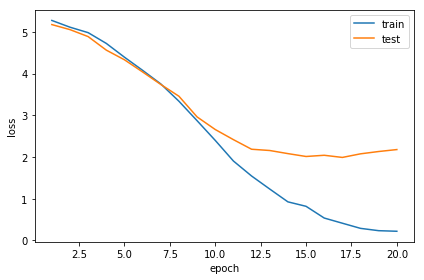

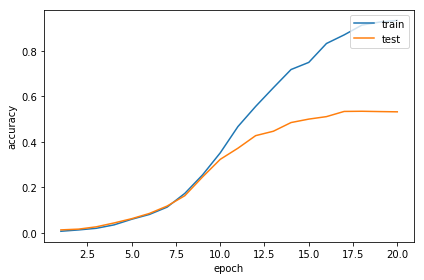

In [10]:
plt.plot(epoch_list, train_loss_list, label='train')
plt.plot(test_epoch_list, test_loss_list, label='test')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['train','test'], loc='upper right')
plt.savefig("loss.png",dpi=250,format="png")
plt.tight_layout()
plt.show()

plt.plot(epoch_list, train_acc_list, label='train')
plt.plot(test_epoch_list, test_acc_list, label='test')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(['train','test'], loc='upper right')
plt.savefig("accuracy.png",dpi=250,format="png")
plt.tight_layout()
plt.show()

In [11]:
print('Accuracy on the ALL test images: %d %%'
      % (100 * total_correct / total))

for i, c in enumerate(classes):
    print('Accuracy of %5s : %2d %%' % (
    c, 100 * class_correct[i] / class_total[i]))


Accuracy on the ALL test images: 53 %
Accuracy of  0149 : 66 %
Accuracy of  0025 : 56 %
Accuracy of  0174 : 58 %
Accuracy of  0151 : 55 %
Accuracy of  0132 : 62 %
Accuracy of  0010 : 51 %
Accuracy of  0122 : 55 %
Accuracy of  0143 : 82 %
Accuracy of  0026 : 58 %
Accuracy of  0146 : 88 %
Accuracy of  0101 : 69 %
Accuracy of  0075 : 25 %
Accuracy of  0121 : 63 %
Accuracy of  0177 : 38 %
Accuracy of  0130 : 56 %
Accuracy of  0067 : 50 %
Accuracy of  0175 : 53 %
Accuracy of  0154 : 45 %
Accuracy of  0079 : 37 %
Accuracy of  0131 : 73 %
Accuracy of  0059 : 40 %
Accuracy of  0169 : 63 %
Accuracy of  0069 : 36 %
Accuracy of  0072 : 40 %
Accuracy of  0128 : 51 %
Accuracy of  0124 : 23 %
Accuracy of  0009 : 34 %
Accuracy of  0032 : 63 %
Accuracy of  0063 : 36 %
Accuracy of  0171 : 65 %
Accuracy of  0024 : 20 %
Accuracy of  0152 : 62 %
Accuracy of  0189 : 62 %
Accuracy of  0044 : 65 %
Accuracy of  0029 : 38 %
Accuracy of  0127 : 65 %
Accuracy of  0136 : 25 %
Accuracy of  0163 : 63 %
Accuracy of 